# Hands-on Activity 5.1 Generating Images with GANs and VAEs

Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Code Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2023-2024
--- | ---
<u>**ACTIVITY NO. 5.1** | **Generating Images with GANs and VAEs**
**Name** | Mendoza, Paulo
--- | ---
**Section** | CPE32S8
**Date Performed**: | April 16, 2024
**Date Submitted**: | April 16, 2024
**Instructor**: | Engr. Roman M. Richard

# Procedures and Discussion: Variational Autoencoders and GANs

In [1]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

print(tf.__version__)

2.15.0


## Part 1: Autoencoders (AEs)

Answer: What is the typical architecture of a 'vanilla/standard/traditional' autoencoder.

### Data: Acquisition and Pre-processing
We will be using Fashion-MNIST, which can be conveniently accessed with Keras.

4422102/4422102 [==============================] - 1s 0us/step
X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


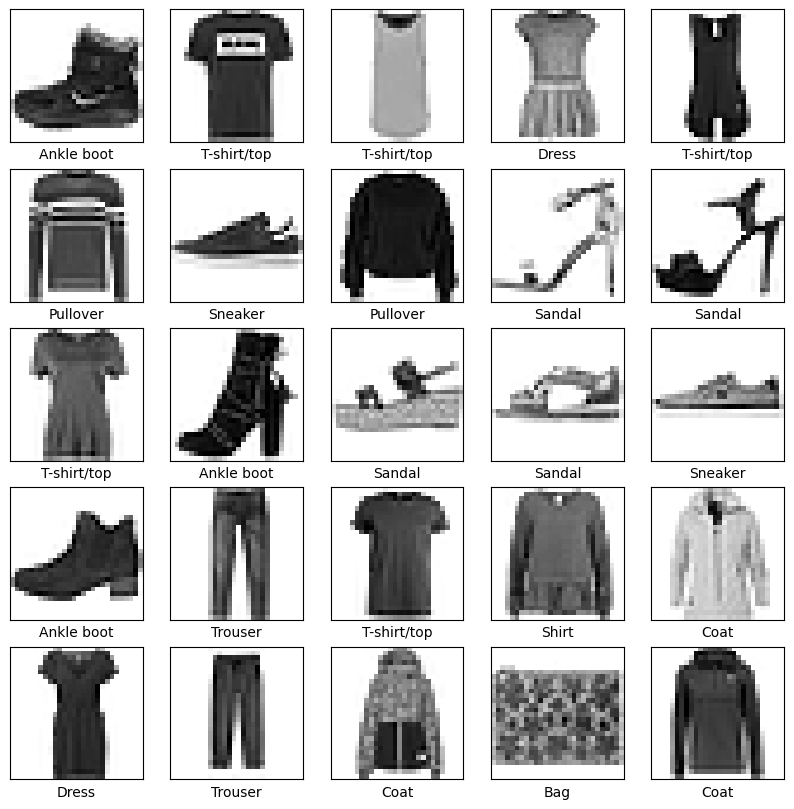

In [2]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

# classes are named 0-9 so define names for plotting clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# display the first 25 garments from the training set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

#### Add Noise to the Images

In attempt to make the autoencoder more robust and not just memorize the inputs, let's add noise to the inputs but calculate its loss based on how similar its outputs are to the original (non-denoised) images.

Check out imgaug docs for more info and other ways to add noise.

In [3]:
# Neural Networks want the inputs to be 3D
n_samples, h, w = X_train.shape

X_train = X_train.reshape(-1, h, w, 1)
X_test = X_test.reshape(-1, h, w, 1)

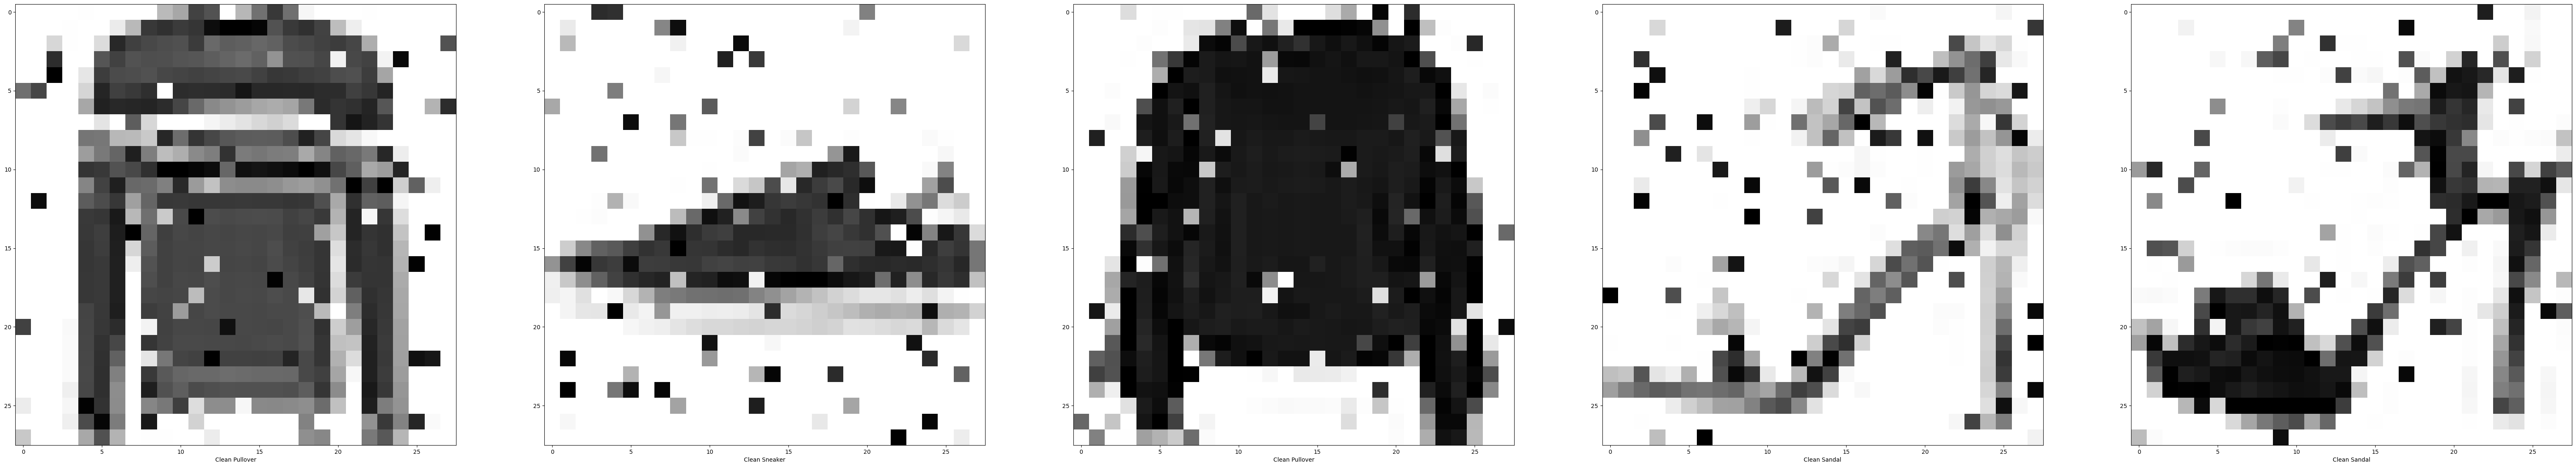

In [4]:
# Adding some 'salt and pepper' noises
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

X_train_n = seq_object.augment_images(X_train * 255) / 255
X_test_n = seq_object.augment_images(X_test * 255) / 255

f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(X_train_n[i, :, :, 0].reshape(28, 28), cmap=plt.cm.binary)
    ax[i-5].set_xlabel('Clean '+class_names[y_train[i]])

#### Create the Autoencoder

In [ ]:
# input layer
input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = tf.keras.layers.Conv2D(64,(3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.Conv2D(32,(3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer2)
encoded_layer3 = tf.keras.layers.Conv2D(16,(3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view = tf.keras.layers.MaxPool2D((2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = tf.keras.layers.UpSampling2D((2, 2))(decoded_layer3)
output_layer = tf.keras.layers.Conv2D(1,(3, 3), padding='same')(decoded_layer3)

# compile the model
model = tf.keras.Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

#### Train the Autoencoder

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')

# epochs=20 for better results
history = model.fit(X_train_n, X_train, epochs=5, batch_size=2048, validation_data=(X_test_n, X_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 232us/sample - loss: 0.0881 - val_loss: 0.0525
Epoch 2/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0431 - val_loss: 0.0356
Epoch 3/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0320 - val_loss: 0.0284
Epoch 4/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0263 - val_loss: 0.0244
Epoch 5/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0234 - val_loss: 0.0225


In [ ]:
n = np.random.randint(0,len(X_test)-5) # pick a random starting index within our test set

#### Visualize Samples reconstructed by AE

**Denoised Images**

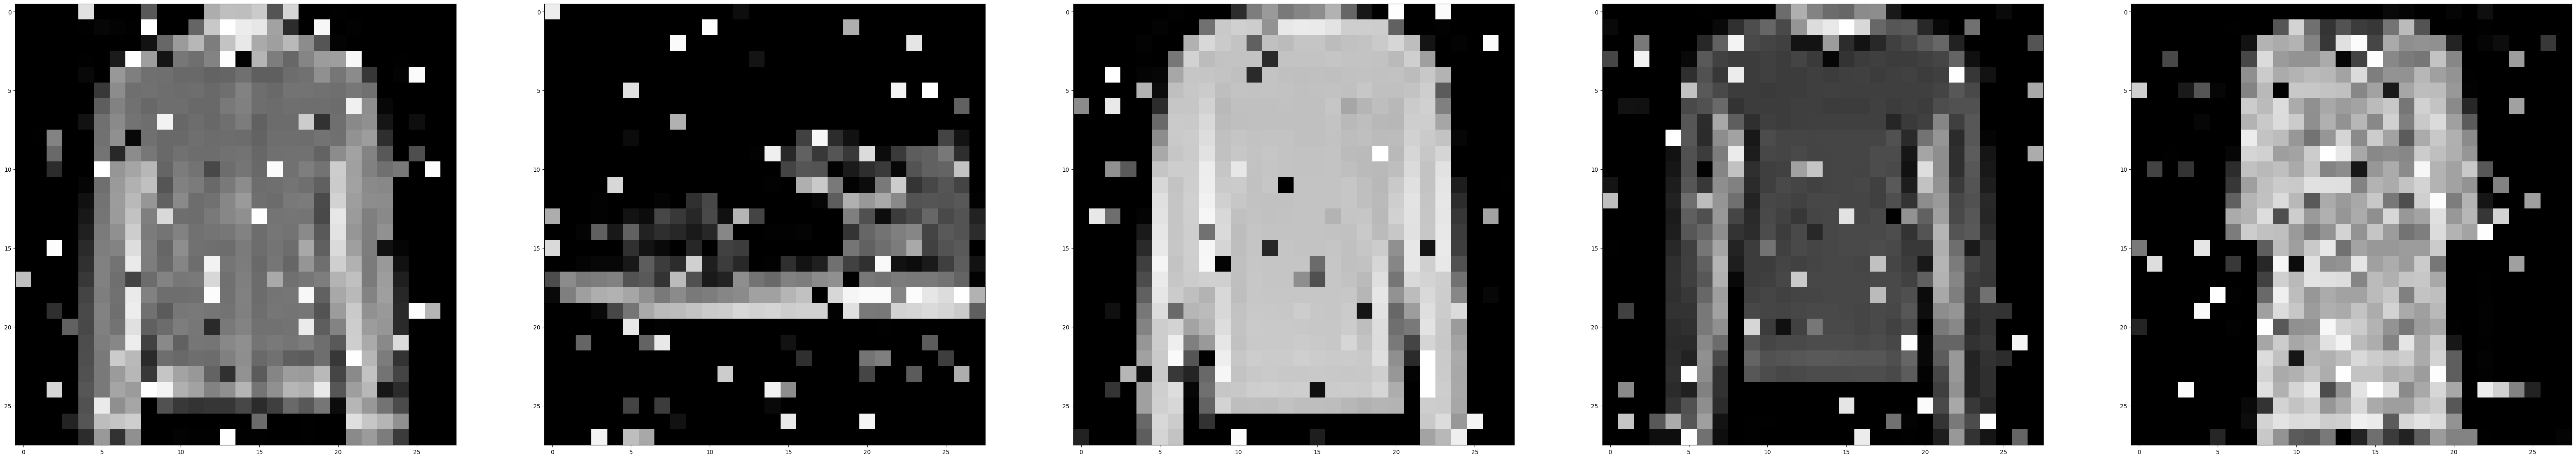

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(X_test_n[a, :, :, 0].reshape(28, 28), cmap='gray')

**Actual Targets (i.e., Original inputs)**

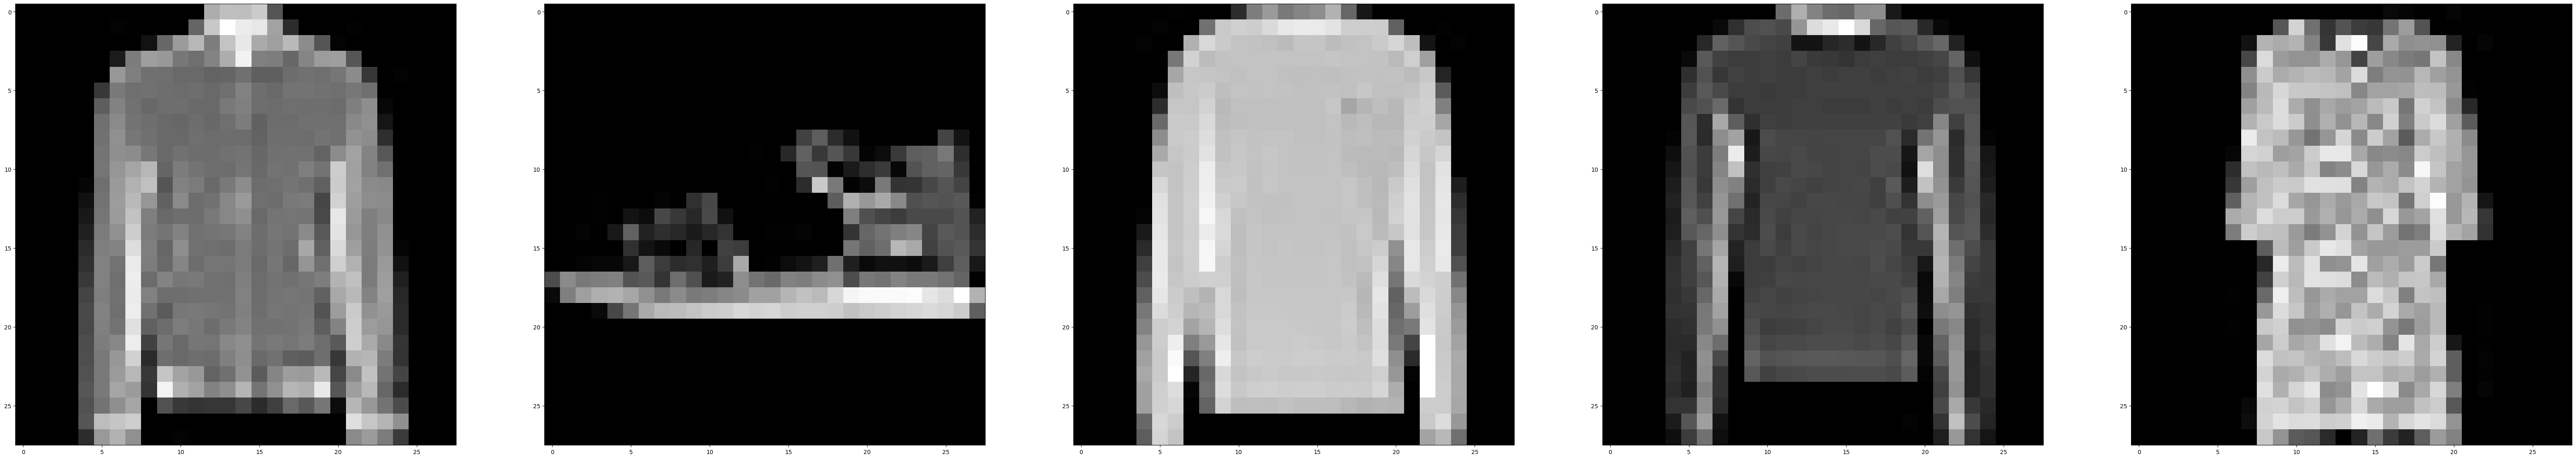

In [ ]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)): # display the 5 images starting at our random index
    ax[i].imshow(X_test[a, :, :, 0].reshape(28, 28), cmap='gray')

**Predicted Images**

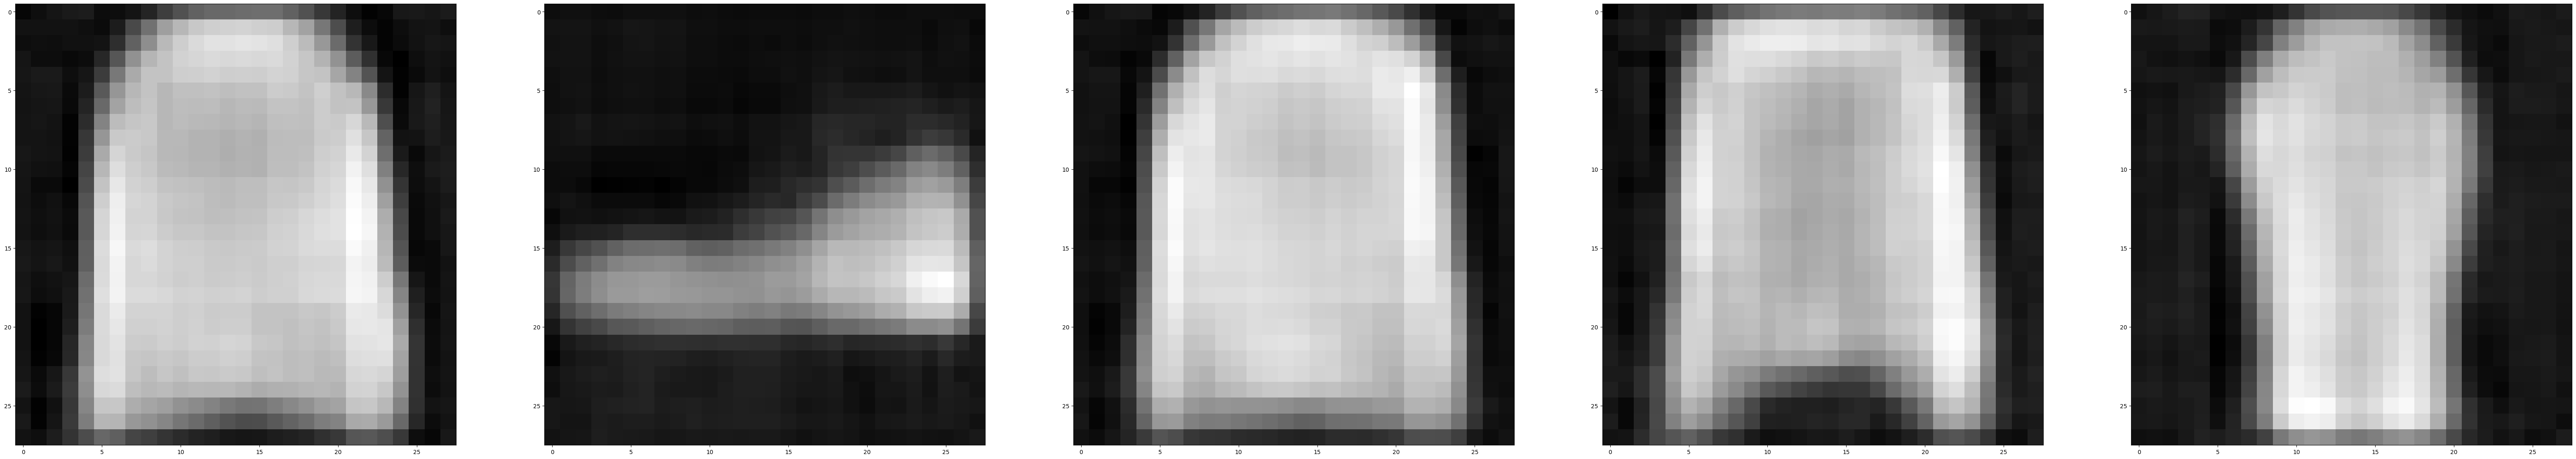

In [ ]:
preds = model.predict(X_test_n[n:n+5])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(preds[i].reshape(28, 28), cmap='gray')
plt.show()

## Part 2: Variational Autoencoders (VAEs)

**Discussion: Why do we care to use VAEs? Identify the limitations/weaknesses of Autoencoders**

### Reset Data

In [ ]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


### Setup Encoder Neural Network

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [ ]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dens  (None, 512)               1536      
 e)                                                              
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403728 (1.54 MB)
Trainable params: 403728 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
z_decoded

<tf.Tensor 'model_1/original_decoder/Sigmoid:0' shape=(None, 784) dtype=float32>

In [ ]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 intermediate_encoder (Dens  (None, 512)                  401920    ['input[0][0]']               
 e)                                                                                               
                                                                                                  
 latent_encoder (Dense)      (None, 2)                    1026      ['intermediate_encoder[0][0]']
                                                                                                  
 dense (Dense)               (None, 2)                    6         ['latent_encoder[0][0]']

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 15s 246us/sample - loss: 0.3590 - val_loss: 0.3411
Epoch 2/4
60000/60000 [==============================] - 12s 192us/sample - loss: 0.3379 - val_loss: 0.3381
Epoch 3/4
60000/60000 [==============================] - 12s 193us/sample - loss: 0.3343 - val_loss: 0.3360
Epoch 4/4
60000/60000 [==============================] - 12s 192us/sample - loss: 0.3324 - val_loss: 0.3315


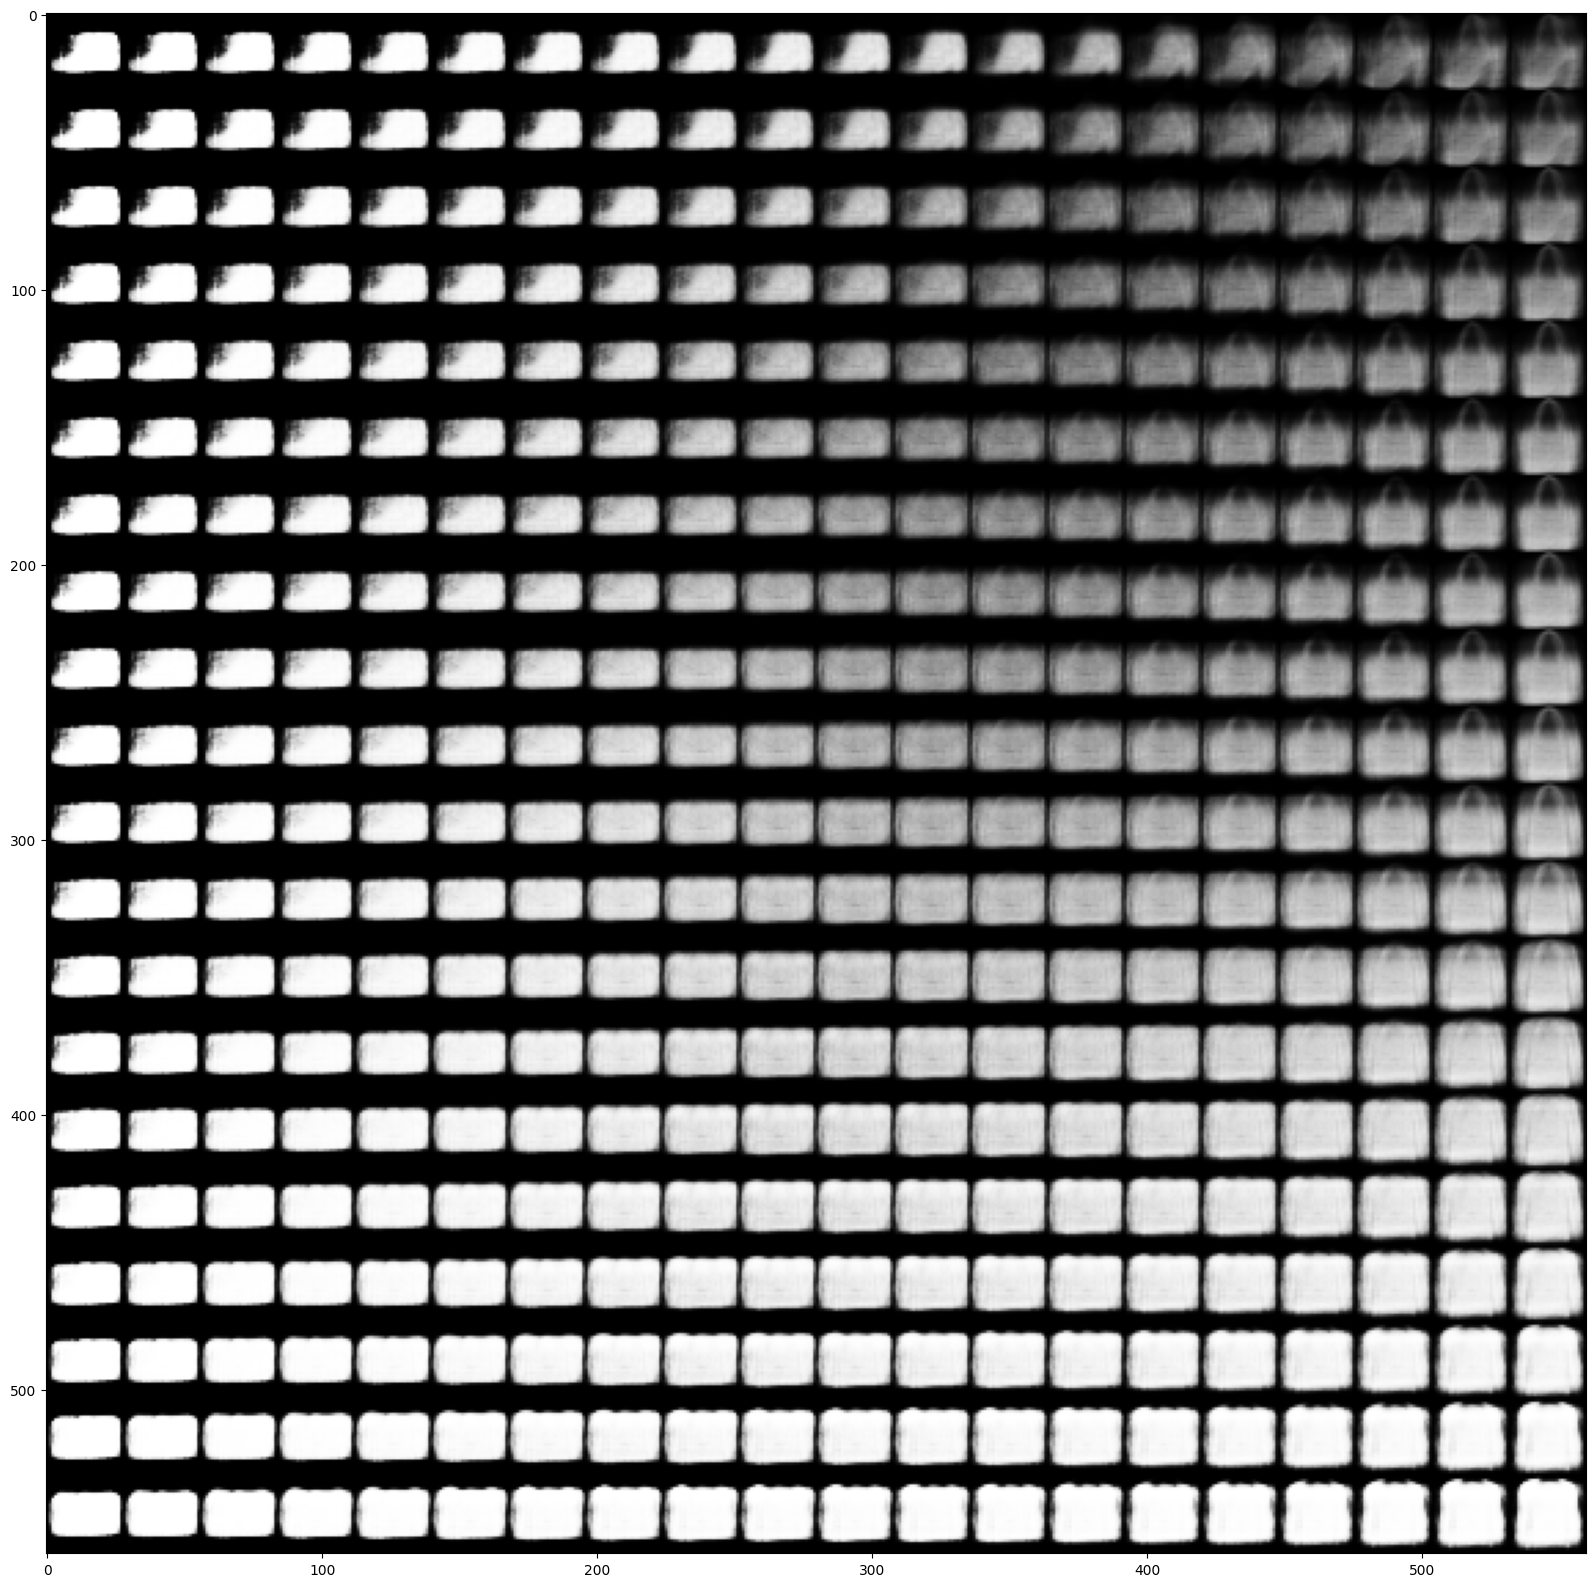

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

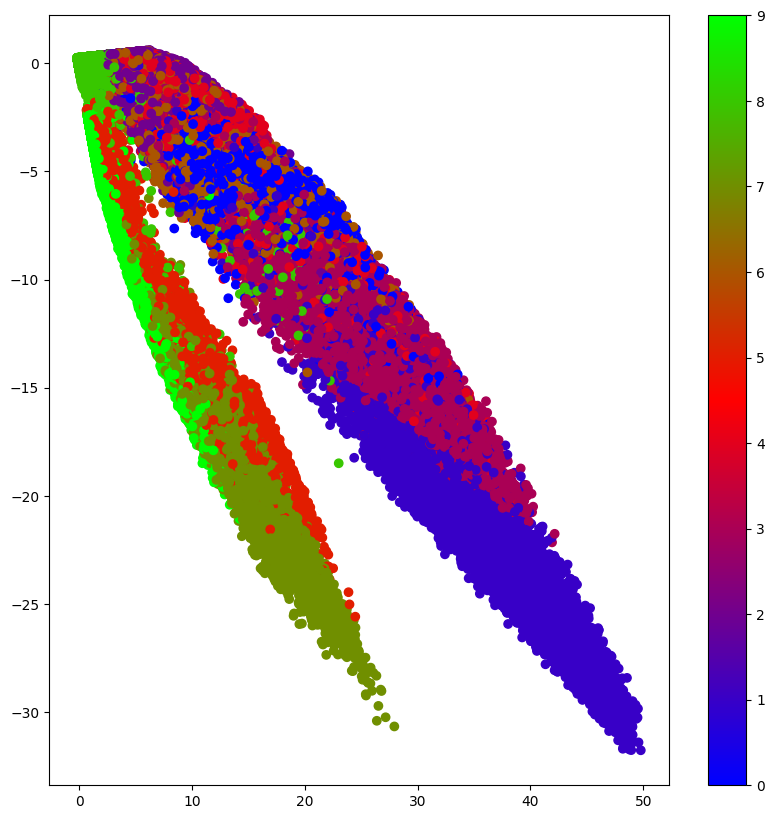

In [ ]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Part 2B: Adding CNNs and KL Divergence Losses

### Generating new fashion

In [ ]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32,3,padding='same', activation='relu')(input_img)
x = Conv2D(64,3,padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)
x = Conv2D(64,3,padding='same', activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

### Setup Sampling Function

In [ ]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim), mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

### Setup Decoder Neural Network
Task: Try different number of hidden layers and nodes?

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

### Setup Loss Function

In [ ]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

### Train VAE

In [ ]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [ ]:
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d_7[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_8[0][0]']            
                                                                                            

In [ ]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

In [ ]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s 349us/sample - loss: 0.3516 - val_loss: 0.3381
Epoch 2/20
60000/60000 [==============================] - 20s 339us/sample - loss: 0.3349 - val_loss: 0.3336
Epoch 3/20
60000/60000 [==============================] - 19s 315us/sample - loss: 0.3316 - val_loss: 0.3316
Epoch 4/20
60000/60000 [==============================] - 20s 327us/sample - loss: 0.3299 - val_loss: 0.3294
Epoch 5/20
60000/60000 [==============================] - 20s 329us/sample - loss: 0.3287 - val_loss: 0.3303
Epoch 6/20
60000/60000 [==============================] - 19s 321us/sample - loss: 0.3279 - val_loss: 0.3298
Epoch 7/20
60000/60000 [==============================] - 19s 322us/sample - loss: 0.3271 - val_loss: 0.3300
Epoch 8/20
60000/60000 [==============================] - 19s 315us/sample - loss: 0.3265 - val_loss: 0.3278
Epoch 9/20
60000/60000 [==============================] - 19s 320us/sample - l

### Visualize Samples Reconstructed by VAE

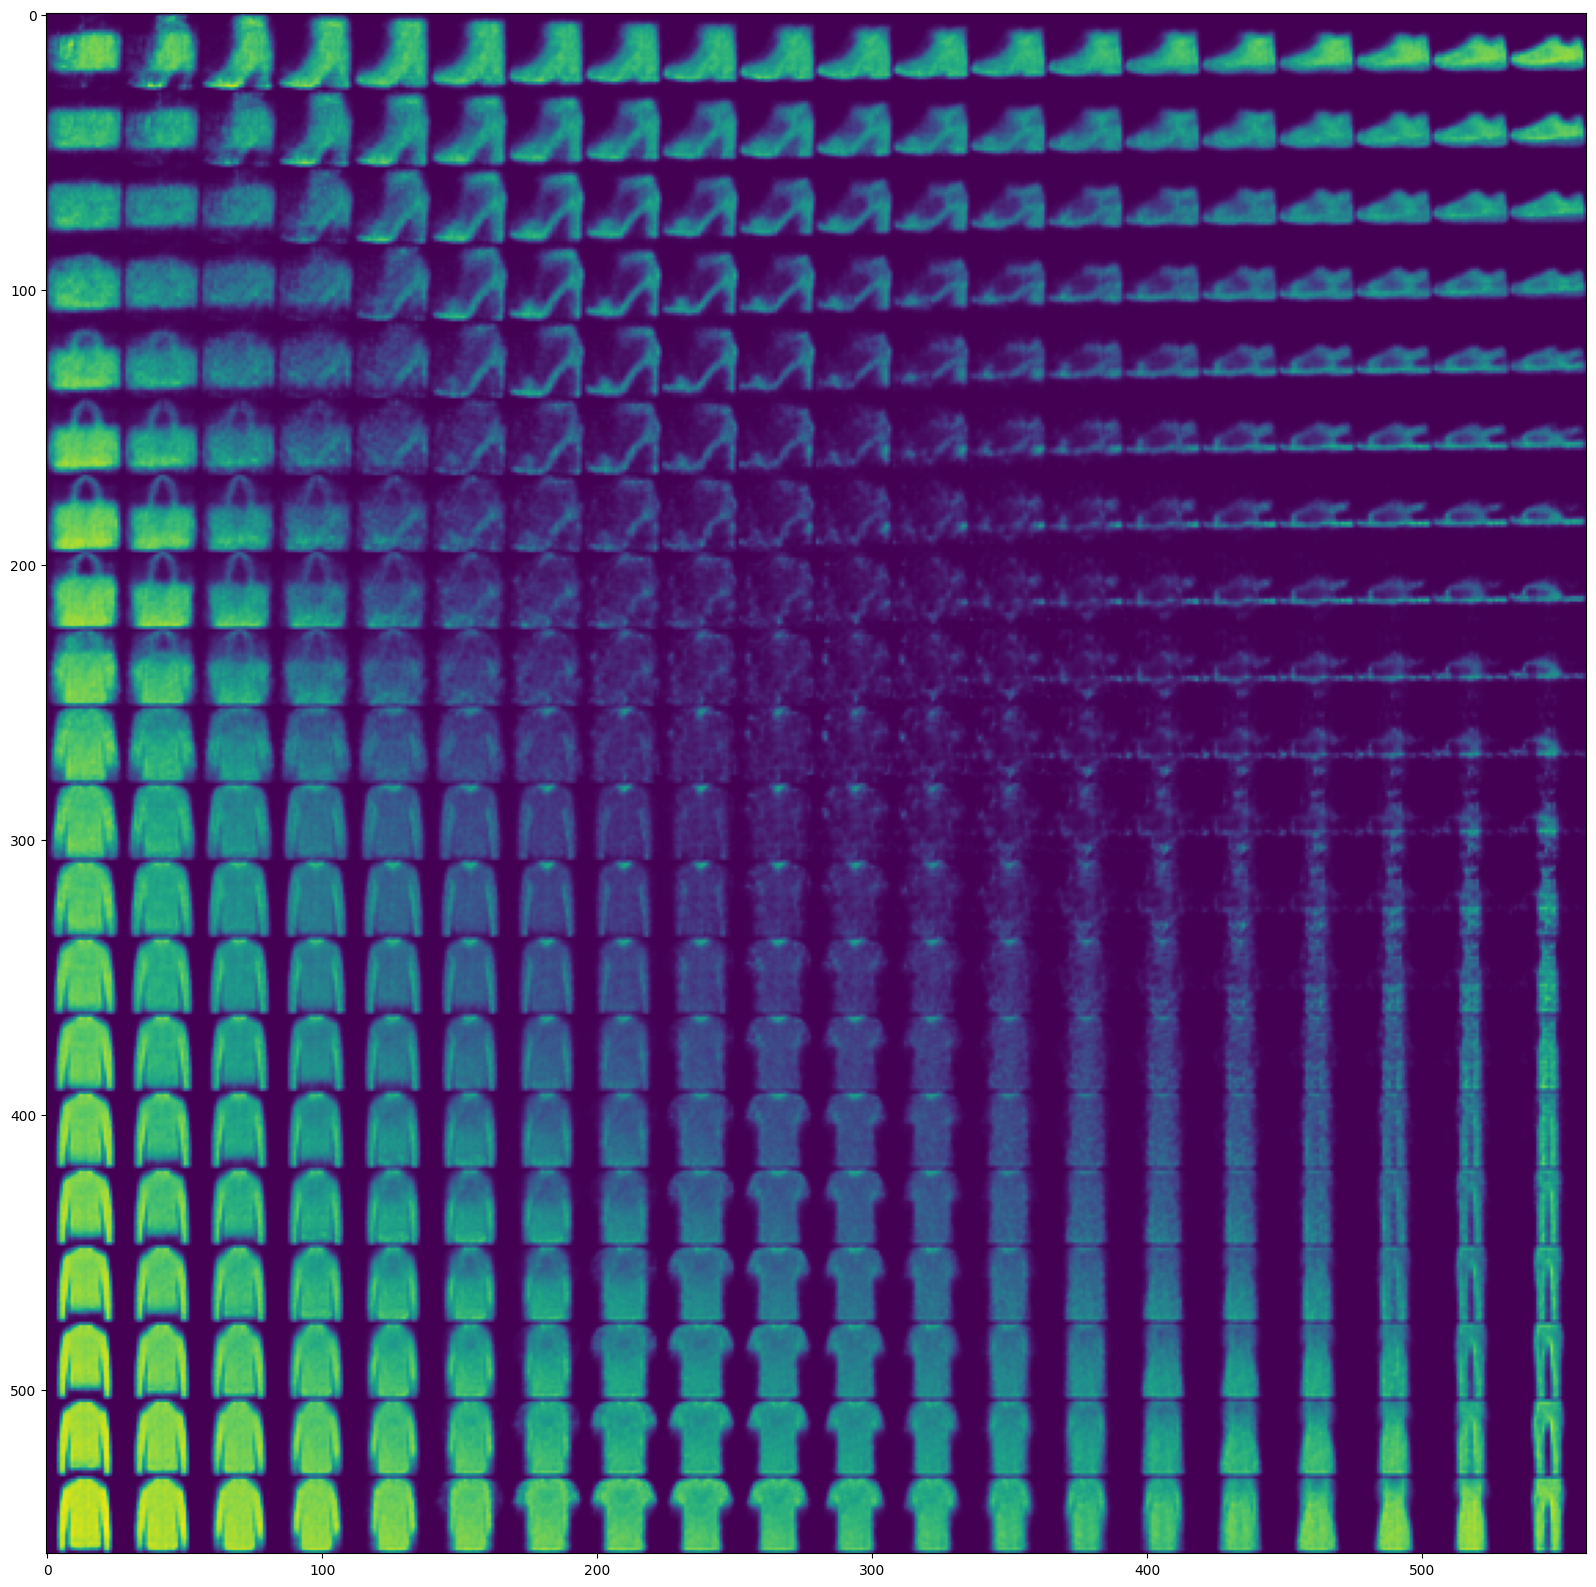

In [ ]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show()

### VAE: Visualize Latent Space

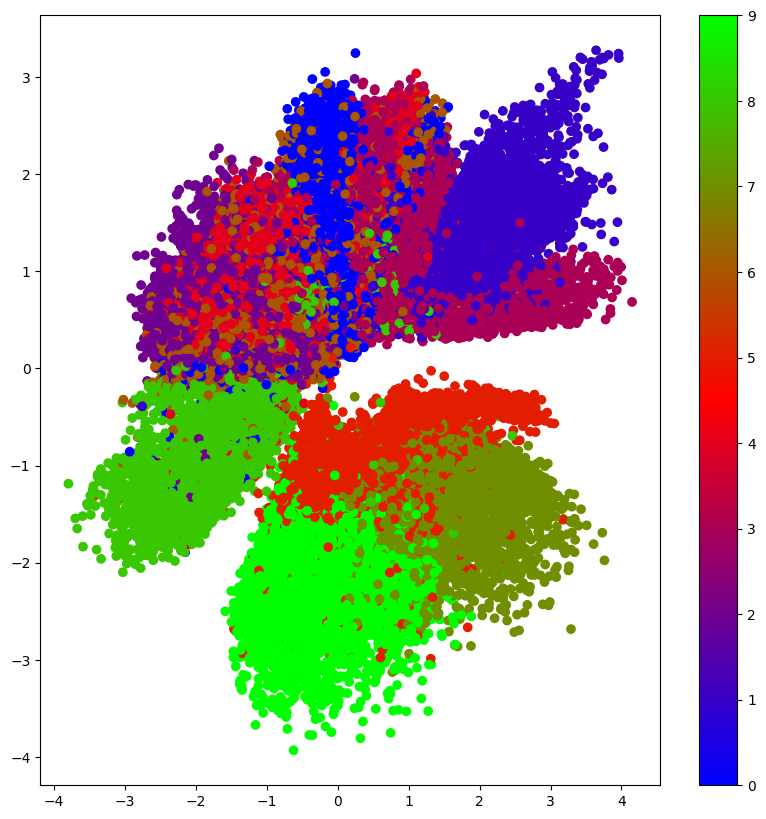

In [ ]:
# Translate into the latent space
encoder = Model(input_img, z_mu)
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=y_train, cmap='brg')
plt.colorbar()
plt.show()

## Exercise: Generating a 1D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [ ]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)

A general function to define feedforward architectures

In [ ]:
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))

  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))

  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

Setting GAN training and losses here

In [ ]:
def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan

In [ ]:
# hyper-parameters
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [ ]:
def train_gan(epochs=1,batch_size=128):
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
    batch_count = x_train.shape[0]/batch_size

    generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
    discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
    gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')

    for e in range(1,epochs+1):

        # generate noise from a uniform distribution
        noise = np.random.rand(batch_size,NOISE_DIM)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]

        generated_values = generator.predict(noise)
        X = np.concatenate([generated_values,true_batch])

        y_dis = np.zeros(2*batch_size)

        #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images,
        #the generator may just produce these features only to exploit the discriminator.
        #The optimization may turn too greedy and produces no long term benefit.
        #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9).
        y_dis[:batch_size] = 0.9

        discriminator.trainable = True
        disc_history = discriminator.train_on_batch(X, y_dis)
        discriminator.trainable = False

        # Train generator
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.zeros(batch_size)
        gan.train_on_batch(noise, y_gen)

    return generator, discriminator

In [ ]:
generator, discriminator = train_gan()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                704       
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                128       
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                               

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0202890242660296 , GAN : [0.02973956]
3rd order moment -  True :  -0.011455162472707944 , GAN : [0.00010549]
4th order moment -  True :  3.1655335130847586 , GAN : [0.0022831]


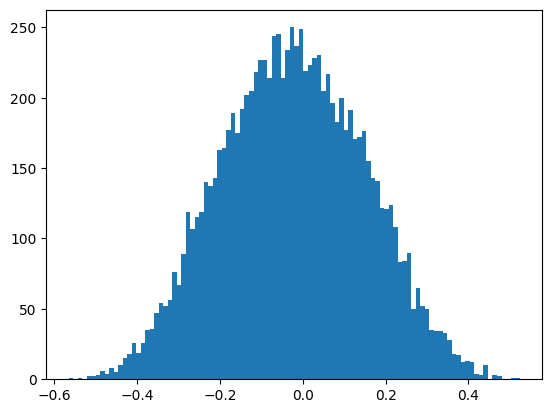

In [ ]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

**CONCLUSION**

Some conclusions we can make from this exercise:
1. GANs are able to learn a generative model from general noise distributions.
2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)


# Supplementary Activities

## Part 1: MNIST GAN - Learn to Generate MNIST Digits

In [5]:
from keras.datasets import mnist
#from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


Re-scale data since we are using ReLU activations. **WHY?**

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Set noise dimension

**EXERCISE : Play around with different noise dimensions and plot the performance with respect to the size of the noise vector.**

In [7]:
z_dim = 100

Tasks:
1. Build Model using LeakyReLU Activations: Build a generator, discriminator, and a GAN as feed-forward network with multiple layers, dropout, and leakyReLU as activation function.
2. Train Model
3. Provide an evaluation/conclusion.

# BUILD MODEL

We are using LeakyReLU activations.

We will build: (a) Generator; (b) Discriminator; and (c) GAN as feed-forward networks with multiple layers, dropout, and LeakyReLU as the activation function.

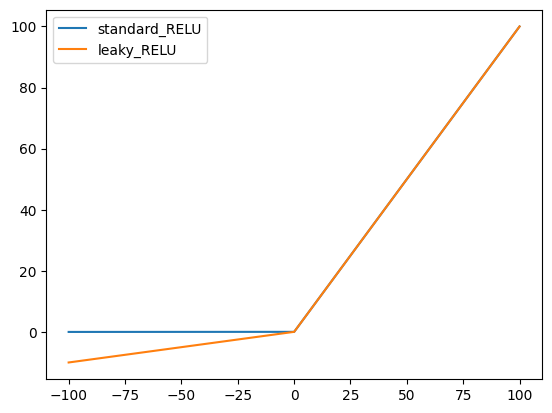

In [8]:
def leakyReLU(x,neg_scale=0.01):
    if x > 0:
        return x
    else:
        return neg_scale*x

std_relu = []
leaky_relu = []

std_relu = [leakyReLU(x,neg_scale=0) for x in np.linspace(-100,100,10000)]
leaky_relu = [leakyReLU(x,neg_scale=0.1) for x in np.linspace(-100,100,10000)]

plt.plot(np.linspace(-100,100,10000),std_relu, label='standard_RELU')
plt.plot(np.linspace(-100,100,10000),leaky_relu, label='leaky_RELU')
plt.legend()
plt.show()

In [9]:
#@title
adam = tf.keras.optimizers.legacy.Adam(lr=0.0002, beta_1=0.5)

# (a) GENERATOR
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# (b) DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# (c) GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Plot losses and generated images preiodically to monitor what the model does.

In [10]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# TRAIN THE MODEL

Generate noise, feed into generator, compare them with discriminator, train the GAN and REPEAT.

In [11]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


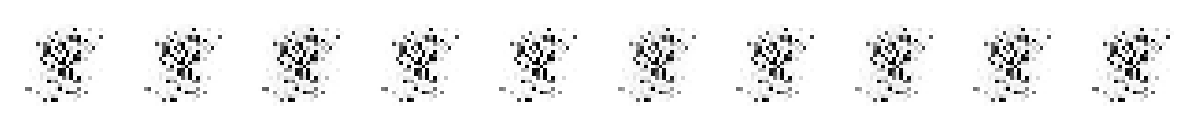

--------------- Epoch 40 ---------------


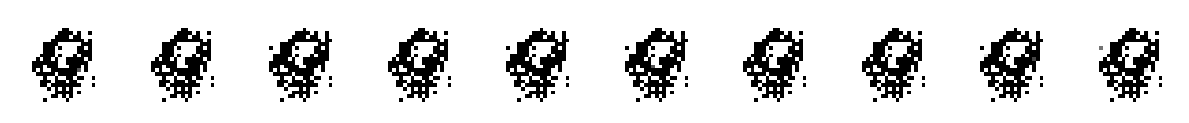

--------------- Epoch 80 ---------------


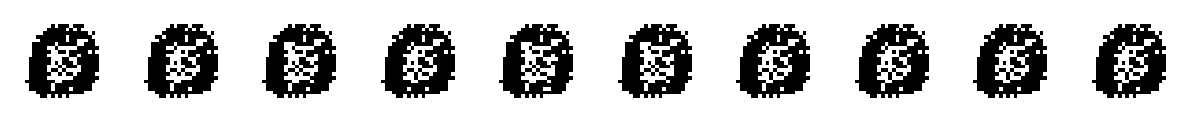

--------------- Epoch 120 ---------------


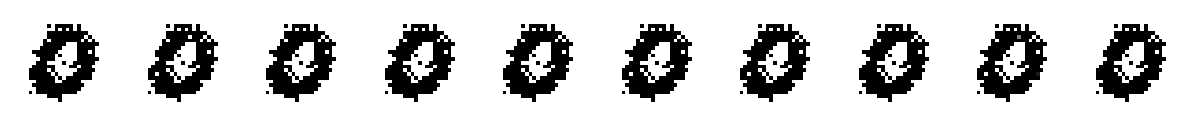

--------------- Epoch 160 ---------------


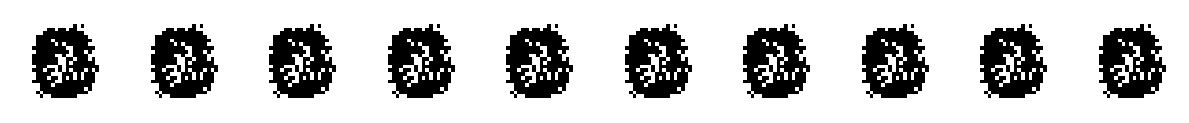

--------------- Epoch 200 ---------------


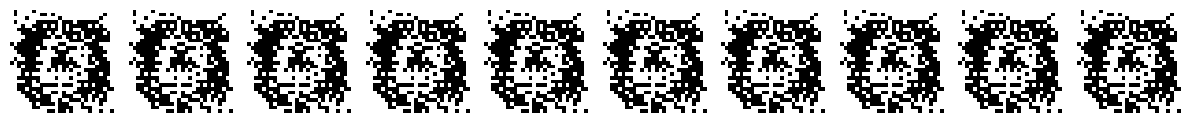

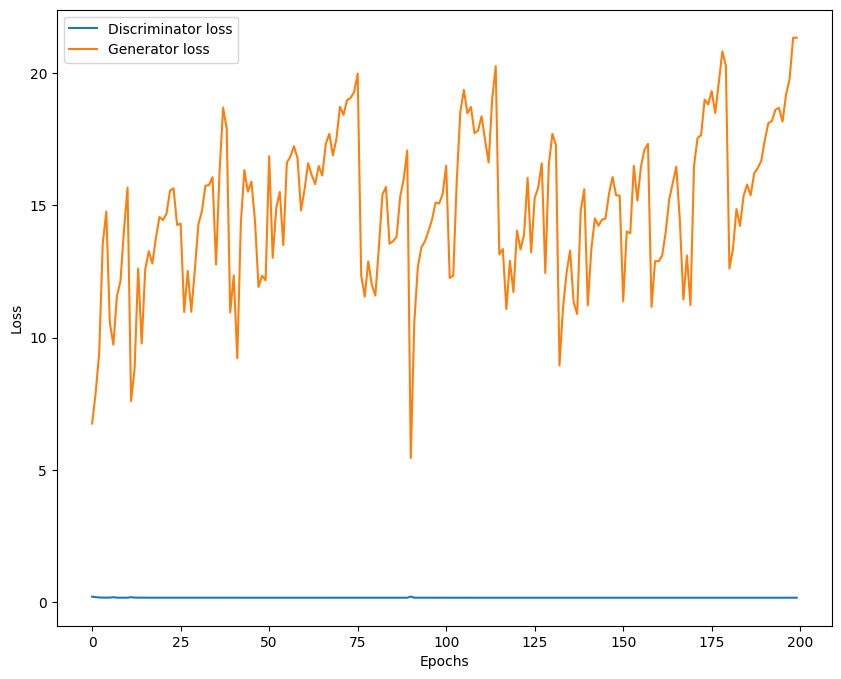

In [12]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)

# Provide an evaluation/conclusion.

## Part 2: GANs and VAEs

Tasks:
1. Use your own dataset.
2. Generate new images using GAN and VAE
3. Compare the results of generating images using GAN and VAE.

# VAEs (own data)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!pip install imgaug
!pip install pandas
!pip install scikit-learn

In [2]:
# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

print(tf.__version__)

2.10.1


In [26]:
# get the data from keras - how convenient!
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data and split it into training and testing sets
(X_train, y_train),(X_test, y_test) = fashion_mnist.load_data()

# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
X_train, X_test = X_train / 255.0, X_test / 255.0

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (60000, 28, 28), X_test shape: (10000, 28, 28)
y_train shape: (60000,), and y_test shape: (10000,)


In [3]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split


In [4]:
home = os.getcwd()
print("Current Working Directory:", home)

Current Working Directory: d:\datasci\projectFiles\hoa_5_1


In [5]:

def load_images_from_folder(folder_path, target_size=(28, 28)):
    images = []
    labels = []
    for fruit_class in os.listdir(folder_path):
        class_path = os.path.join(folder_path, fruit_class)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            img = img.convert('L')  # Convert to grayscale
            img = img.resize(target_size)
            img_array = np.array(img)
            # Normalize pixel values to range [0, 1]
            img_array = img_array.astype(np.float32) / 255.0
            images.append(img_array)
            labels.append(fruit_class)
    return np.array(images), np.array(labels)



In [7]:
data_folder = rf'{home}/processed_data'

# Load images and labels
X, y = load_images_from_folder(data_folder)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to match the expected shape for model training
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)


In [9]:
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}, and y_test shape: {y_test.shape}')

X_train shape: (320, 28, 28), X_test shape: (80, 28, 28)
y_train shape: (320,), and y_test shape: (80,)


In [10]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = tf.keras.layers.Input(shape=(784,), name="input")
x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = tf.keras.layers.Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

In [11]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mu)[0], latent_dim))
    z = z_mu + tf.keras.backend.exp(z_log_sigma) * epsilon
    return z

# sample vector from the latent distribution
z = tf.keras.layers.Lambda(sampling)([z_mu, z_log_sigma])

In [12]:
# decoder takes the latent distribution sample as input
decoder_input = tf.keras.layers.Input((2,), name="input_decoder")

x = tf.keras.layers.Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = tf.keras.layers.Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = tf.keras.Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [13]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_decoder (InputLayer)  [(None, 2)]               0         
                                                                 
 intermediate_decoder (Dense  (None, 512)              1536      
 )                                                               
                                                                 
 original_decoder (Dense)    (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [14]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = tf.keras.backend.flatten(x)
        z_decoded = tf.keras.backend.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = tf.keras.losses.binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [15]:
z_decoded

<tf.Tensor 'model/original_decoder/Sigmoid:0' shape=(None, 784) dtype=float32>

In [16]:
# VAE model statement
vae = tf.keras.Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [17]:
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 intermediate_encoder (Dense)   (None, 512)          401920      ['input[0][0]']                  
                                                                                                  
 latent_encoder (Dense)         (None, 2)            1026        ['intermediate_encoder[0][0]']   
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['latent_encoder[0][0]']         
                                                                                            

In [18]:
X_train.shape

(320, 28, 28)

In [8]:
# this code flatens the 28*28 into just 784
train_x = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
val_x = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [20]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=4,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 320 samples, validate on 80 samples
Epoch 1/4
320/320 [==============================] - 2s 5ms/sample - loss: 0.6311 - val_loss: 0.5763
Epoch 2/4
320/320 [==============================] - 0s 262us/sample - loss: 0.5628 - val_loss: 0.5339
Epoch 3/4
320/320 [==============================] - 0s 243us/sample - loss: 0.5329 - val_loss: 0.5208
Epoch 4/4
320/320 [==============================] - 0s 241us/sample - loss: 0.5239 - val_loss: 0.5116


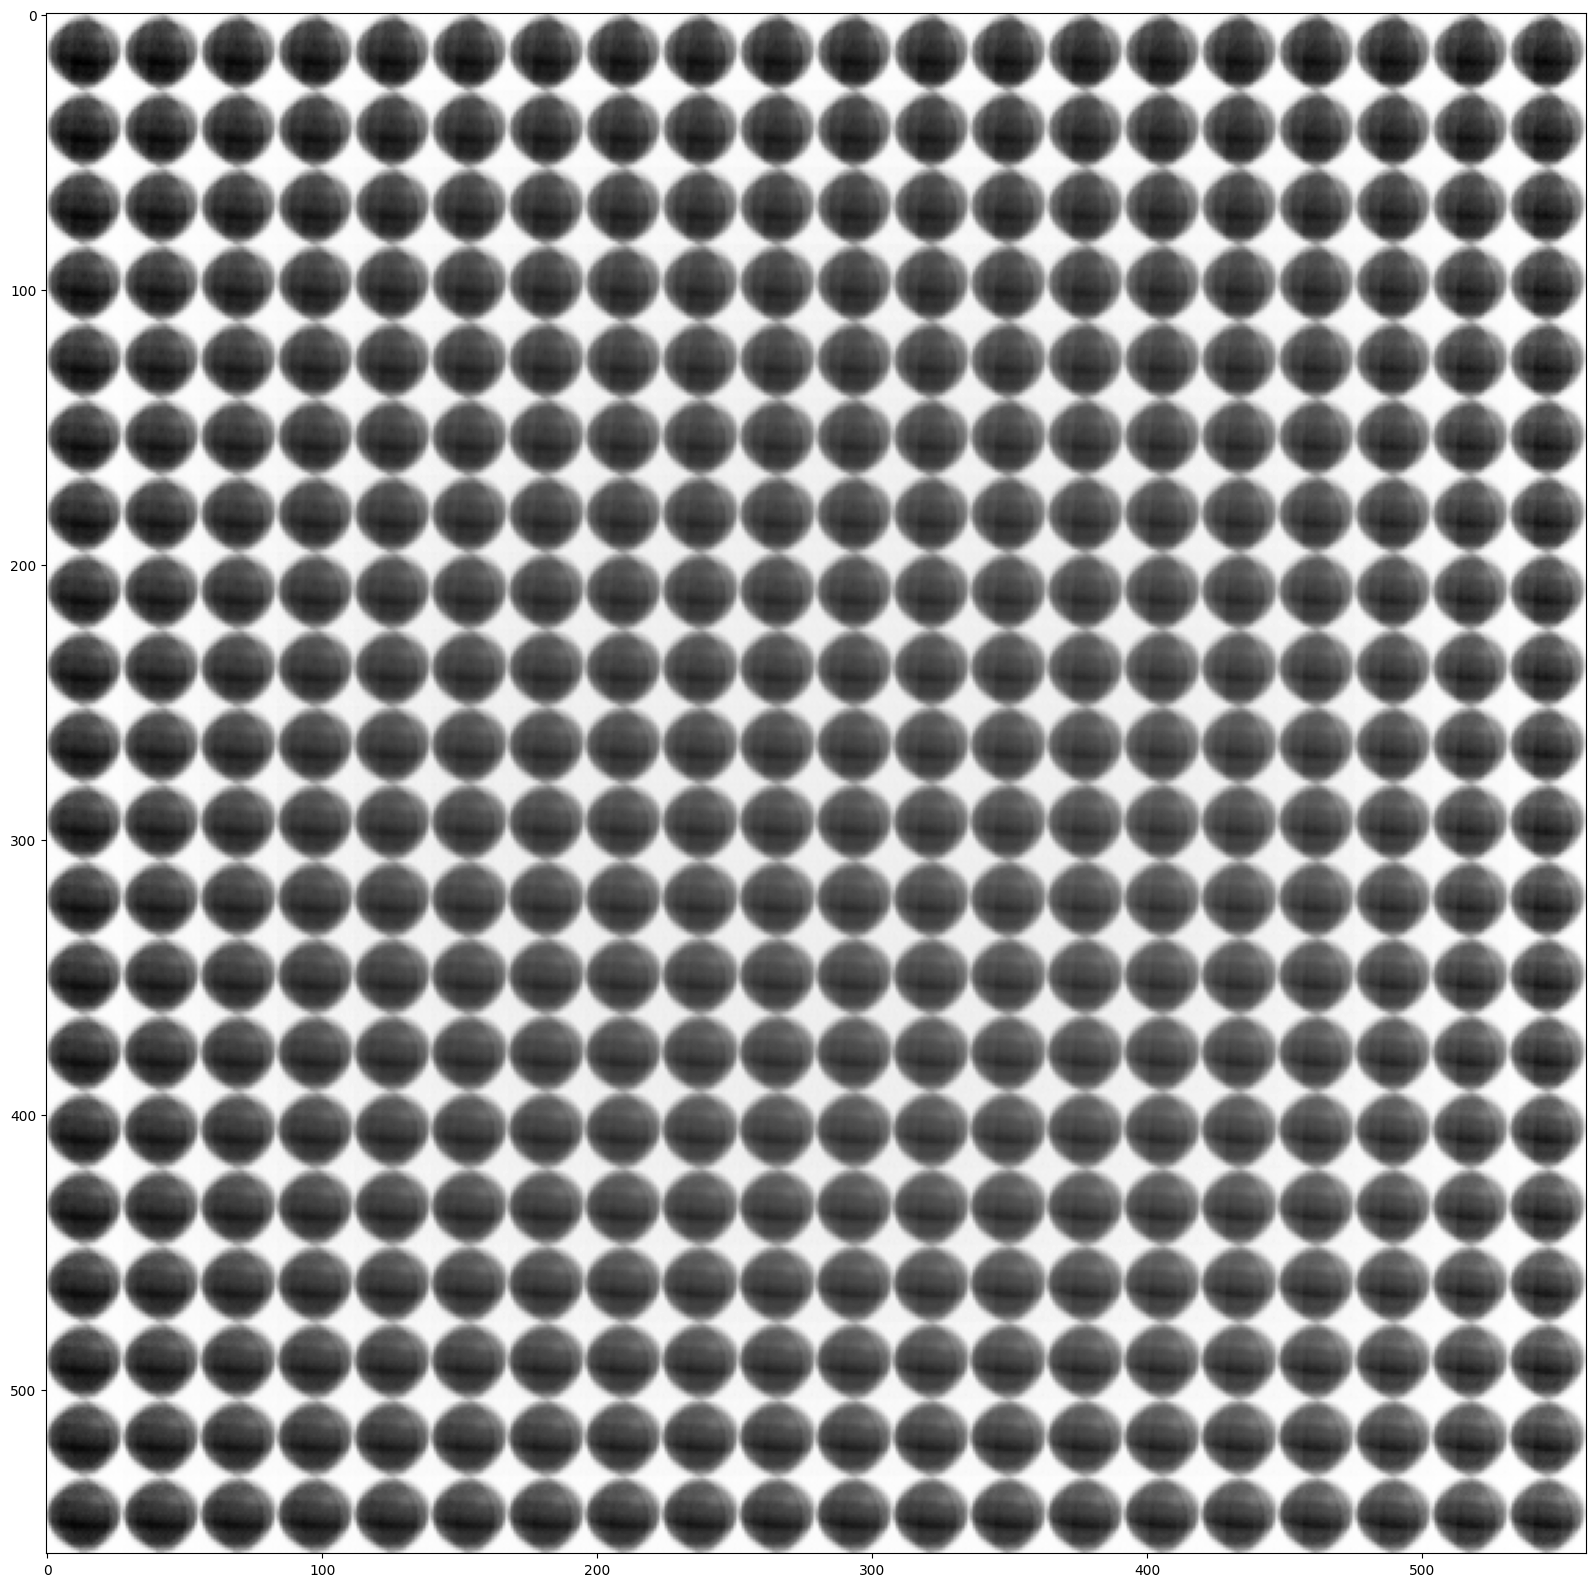

In [21]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

In [22]:
y_train

array(['Avocado_subset', 'Avocado_subset', 'Tomato_subset',
       'Tomato_subset', 'Tomato_subset', 'Avocado_subset',
       'Tomato_subset', 'Watermelon_subset', 'Corn_subset',
       'Avocado_subset', 'Tomato_subset', 'Watermelon_subset',
       'Corn_subset', 'Tomato_subset', 'Corn_subset', 'Watermelon_subset',
       'Watermelon_subset', 'Watermelon_subset', 'Tomato_subset',
       'Avocado_subset', 'Tomato_subset', 'Corn_subset', 'Avocado_subset',
       'Avocado_subset', 'Corn_subset', 'Avocado_subset',
       'Avocado_subset', 'Corn_subset', 'Watermelon_subset',
       'Watermelon_subset', 'Corn_subset', 'Watermelon_subset',
       'Tomato_subset', 'Watermelon_subset', 'Tomato_subset',
       'Avocado_subset', 'Avocado_subset', 'Tomato_subset',
       'Watermelon_subset', 'Tomato_subset', 'Corn_subset', 'Corn_subset',
       'Avocado_subset', 'Watermelon_subset', 'Avocado_subset',
       'Corn_subset', 'Watermelon_subset', 'Watermelon_subset',
       'Corn_subset', 'Tomato_subs

In [23]:
# Sample array of fruit names
fruit_names = y_train

# Define a mapping of fruit names to integer labels
fruit_mapping = {"Avocado_subset": 0, "Corn_subset": 1, "Tomato_subset": 2, "Watermelon_subset": 2}

# Convert fruit names to integer labels using list comprehension
int_labels = [fruit_mapping[name] for name in fruit_names]

print(int_labels)


[0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 0, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1]


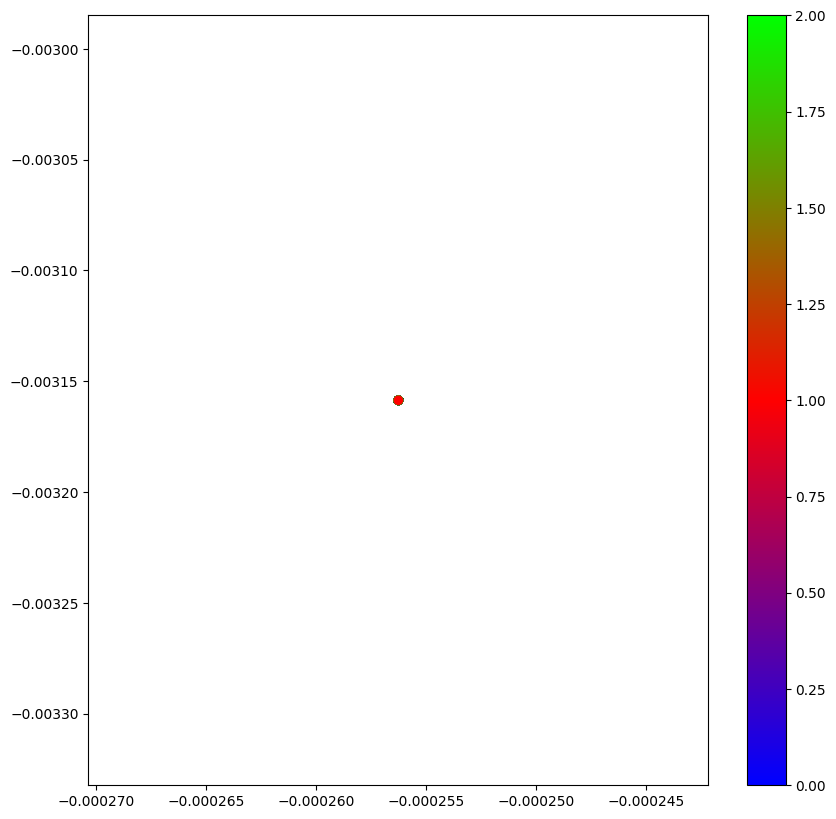

In [24]:
# Translate into the latent space
encoder = tf.keras.Model(input_img, z_mu) # works on older version of TF and Keras
x_valid_noTest_encoded = encoder.predict(train_x, batch_size=batch_size)
plt.figure(figsize=(10, 10))
plt.scatter(x_valid_noTest_encoded[:, 0], x_valid_noTest_encoded[:, 1], c=int_labels, cmap='brg')
plt.colorbar()
plt.show()

# GAN (own data)

In [27]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
print(tf.__version__)

# system libraries
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

# image libraries
import cv2 # requires installing opencv (e.g., pip install opencv-python)
from imgaug import augmenters # requires installing imgaug (e.g., pip install imgaug)

# math/numerical libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from sklearn.model_selection import train_test_split

import tensorflow as tf

# deep learning libraries
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop

from keras.layers import *
from keras import backend as K
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical
# from keras.metrics import *
# from keras.preprocessing import image, sequence
#
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

print(tf.__version__)

2.10.1
2.10.1


In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

home = os.getcwd()
print("Current Working Directory:", home)

def load_images_from_folder(folder_path, target_size=(28, 28)):
    images = []
    labels = []
    for fruit_class in os.listdir(folder_path):
        class_path = os.path.join(folder_path, fruit_class)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            img = img.convert('L')  # Convert to grayscale
            img = img.resize(target_size)
            img_array = np.array(img)
            # Normalize pixel values to range [0, 1]
            img_array = img_array.astype(np.float32) / 255.0
            images.append(img_array)
            labels.append(fruit_class)
    return np.array(images), np.array(labels)

Current Working Directory: d:\datasci\projectFiles\hoa_5_1


In [3]:
import tensorflow as tf
print(tf.__version__)
from keras.datasets import mnist
#from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
#from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
#(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

2.10.1


In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {Y_train.shape}, and y_test shape: {Y_test.shape}')

X_train shape: (60000, 784), X_test shape: (10000, 784)
y_train shape: (60000,), and y_test shape: (10000,)


In [8]:
data_folder = rf'{home}/processed_data'

# Load images and labels
X, y = load_images_from_folder(data_folder)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to match the expected shape for model training
X_train = X_train.reshape(-1, 28, 28)
X_test = X_test.reshape(-1, 28, 28)

# this code flatens the 28*28 into just 784
X_train = X_train.reshape(-1,784) # train_x.reshape(-1, 784)
X_test = X_test.reshape(-1,784) #val_x.reshape(-1, 784)

In [9]:
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
print(f'y_train shape: {Y_train.shape}, and y_test shape: {Y_test.shape}')

X_train shape: (320, 784), X_test shape: (80, 784)
y_train shape: (320,), and y_test shape: (80,)


In [10]:
z_dim = 100

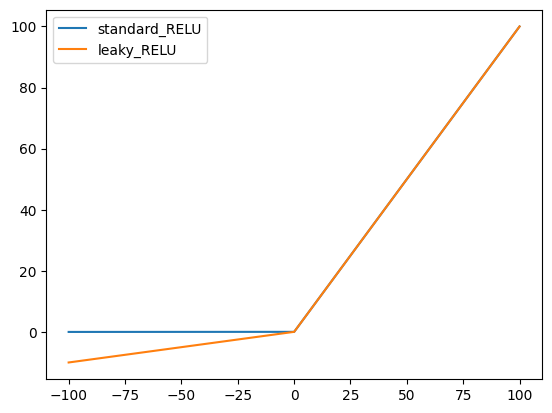

In [11]:
def leakyReLU(x,neg_scale=0.01):
    if x > 0:
        return x
    else:
        return neg_scale*x

std_relu = []
leaky_relu = []

std_relu = [leakyReLU(x,neg_scale=0) for x in np.linspace(-100,100,10000)]
leaky_relu = [leakyReLU(x,neg_scale=0.1) for x in np.linspace(-100,100,10000)]

plt.plot(np.linspace(-100,100,10000),std_relu, label='standard_RELU')
plt.plot(np.linspace(-100,100,10000),leaky_relu, label='leaky_RELU')
plt.legend()
plt.show()

In [12]:
#@title
adam = tf.keras.optimizers.legacy.Adam(lr=0.0002, beta_1=0.5)

# (a) GENERATOR
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# (b) DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# (c) GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [13]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)

        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


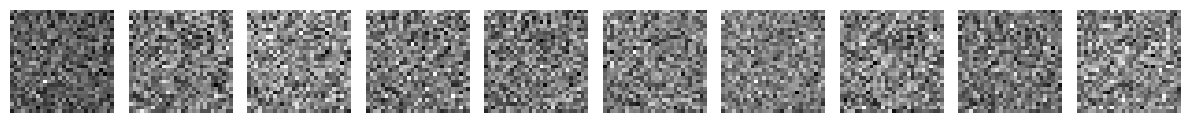

--------------- Epoch 40 ---------------


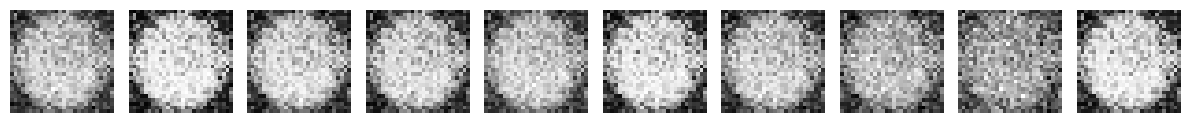

--------------- Epoch 80 ---------------


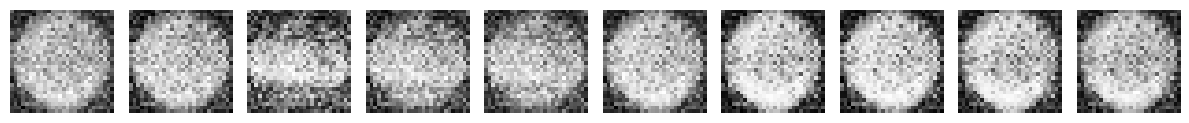

--------------- Epoch 120 ---------------


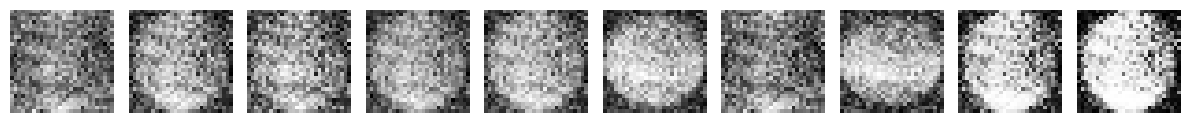

--------------- Epoch 160 ---------------


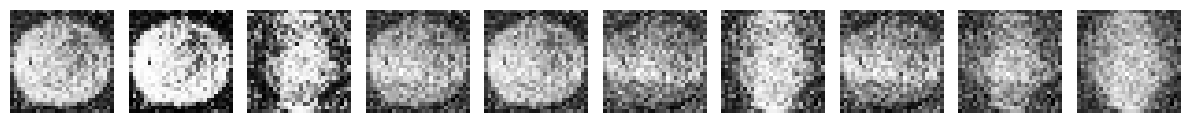

--------------- Epoch 200 ---------------


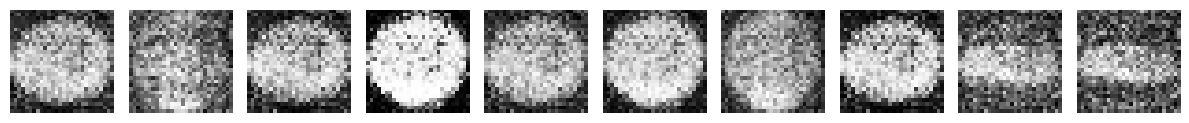

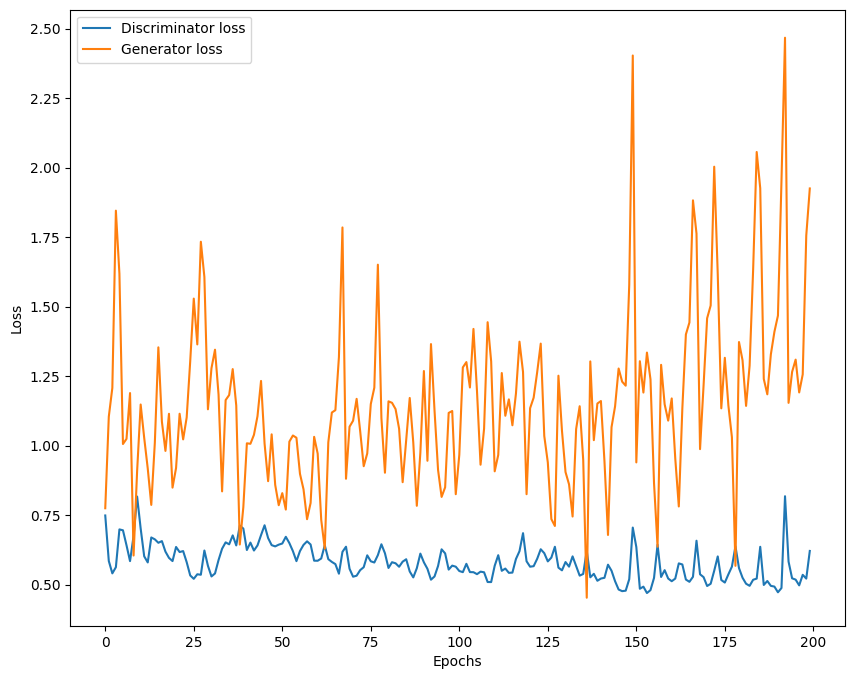

In [15]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)

# Conclusion

Generative adversarial networks (GANs) and variational autoencoders (VAEs) one of its purpose is to generate content by A.I. in this activity is generating images. GANs do it by using generator and a discriminator. This works by generator creating an image then the discriminator tell whether it is fake or not. Both generator and discriminator improve by the results from each other. While VAEs uses encoder and decoder. The encoder compresses the shape of the data to learn it's latent features then uses the decoder to reconstruct the image with it's original shape

# Github Link:

https://github.com/Abyza/CPE313/tree/main/HOA_5_1_Generating_Images_with_GANs_and_VAEs

# References


> **Variational Autoencoders and GANs**
>
> Harvard University
>
> Fall 2020
>
> Instructors: Mark Glickman, Pavlos Protopapas, and Chris Tanner
>
> Lab Instructors: Chris Tanner and Eleni Angelaki Kaxiras
>
> Content: Srivatsan Srinivasan, Pavlos Protopapas, Chris Tanner
>
> Link: https://harvard-iacs.github.io/2020-CS109B/labs/lab10/notebook/

